<a href="https://colab.research.google.com/github/aghosh92/ML-ElectronMicroscopy-2023/blob/main/Lecture%2012/Optional_Notebook_V.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Notebook is prepared by Ayana Ghosh**

Email: research.aghosh@gmail.com

### This notebook shows an example how to use the simulation object as prepared by AtomAI to run a sample MD simulation with LAMMPS-python. Here  we utilize Tersoff potnetial.

### The example follows a similar workflow (simulation object prepared by AtomAI to perform simulations) as described in this paper, https://www.nature.com/articles/s41524-022-00733-7, provided DFT simulations were performed in this work for structure optimization followed by finite temperature AIMD simulations were performed on patches of the full system to generate results on energy landscape, dopant and graphene healing effects.

In [ ]:
#@title Install LAMMPS environment
!apt install ccache cmake build-essential git python3.7-venv libfftw3-dev
!git clone https://github.com/lammps/lammps.git
%cd /content/lammps/
!mkdir build
%cd build
!ls ../cmake/presets
!cmake -C ../cmake/presets/gcc.cmake -D CMAKE_INSTALL_PREFIX=/usr -D CMAKE_CXX_COMPILER_LAUNCHER=ccache -D BUILD_SHARED_LIBS=on -D LAMMPS_EXCEPTIONS=on -D PKG_PYTHON=on -D PKG_MANYBODY=on ../cmake
!pwd
!make -j 2
!make install
!make install-python
!ls
!pwd
%cd /content/lammps/
!lmp -in examples/melt/in.melt
# Copy executable file to where the python Module locates
import shutil
src_path = './build/liblammps.so'
dist_path = '/usr/local/lib/python3.7/dist-packages/liblammps.so'
#dist_path = '/usr/local/lib/liblammps.so'

shutil.copyfile(src_path,dist_path)

# Naviagate back to main folder before simulation
%cd /content
print('\n')
print('LAMMPS-Python Integration is completed!')

!ls -lah /usr/local/lib/python3.7/dist-packages/liblammps.so

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.2).
git is already the newest version (1:2.17.1-1ubuntu0.13).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libfftw3-bin libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  distcc libfftw3-doc
The following NEW packages will be installed:
  ccache libfftw3-bin libfftw3-dev libfftw3-long3 libfftw3-quad3
  libfftw3-single3 python3.7-venv
0 upgraded, 7 newly installed, 0 to remove and 29 not upgraded.
Need to get 6,392 kB of archives.
After this operation, 24.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 ccache amd64 3.4.1-1 [110 kB]
Get:2 http://ppa.launchpad.net/

In [ ]:
!pip install wget

In [ ]:
#@title Install ASE
!pip install -q ase

     |████████████████████████████████| 2.2 MB 7.5 MB/s 


In [ ]:
#@title Import essential libraries
import os
import numpy as np
from ase import Atoms, Atom
import ase.io as io

from ase.io import read,write
from ase.io.vasp import read_vasp
from ase.calculators.lammpslib import LAMMPSlib
from ase.io.trajectory import Trajectory
from ase.optimize import QuasiNewton
from ase.optimize.bfgslinesearch import BFGSLineSearch
from ase.md.velocitydistribution import (MaxwellBoltzmannDistribution, Stationary, ZeroRotation)
from ase.md.verlet import VelocityVerlet
from ase import units
from ase.io.animation import write_mp4
from ase.calculators.lj import LennardJones
from ase.io.pov import get_bondpairs, set_high_bondorder_pairs
from ase.data.colors import jmol_colors
from ase.data import covalent_radii
from ase.geometry import wrap_positions

import cv2 as cv
import glob
import imageio
import wget

Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Read in the Tersoff potential

In [ ]:
!wget https://www.ctcms.nist.gov/potentials/testing/Download/2005--Erhart-P-Albe-K--Si-C-II/1/2005_SiC_II.tersoff

--2022-10-29 15:21:56--  https://www.ctcms.nist.gov/potentials/testing/Download/2005--Erhart-P-Albe-K--Si-C-II/1/2005_SiC_II.tersoff
Resolving www.ctcms.nist.gov (www.ctcms.nist.gov)... 129.6.13.19, 2610:20:6005:13::19
Connecting to www.ctcms.nist.gov (www.ctcms.nist.gov)|129.6.13.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1688 (1.6K)
Saving to: ‘2005_SiC_II.tersoff.1’

2005_SiC_II.tersoff 100%[===================>]   1.65K  --.-KB/s    in 0s      

2022-10-29 15:21:57 (28.7 MB/s) - ‘2005_SiC_II.tersoff.1’ saved [1688/1688]



Read in the newly created object that is readable by ASE that can be used to perform molecular dynamics simulations.

In [ ]:
# #drive link
# !gdown https://drive.google.com/uc?id=1ByrcGe0sMsrx5iW4jj5S3oAAYa0kC70C
# atoms = io.vasp.read_vasp("/content/POSCAR_basic")
!wget -O POSCAR_basic https://www.dropbox.com/s/nqbl7th8mnea7mf/POSCAR_basic?dl=0
atoms = io.vasp.read_vasp("POSCAR_basic")

Downloading...
From: https://drive.google.com/uc?id=1ByrcGe0sMsrx5iW4jj5S3oAAYa0kC70C
To: /content/POSCAR_basic
100% 64.9k/64.9k [00:00<00:00, 57.7MB/s]


In [ ]:
def printenergy(a):
# function to print the potential, kinetic and total energy
  epot = a.get_potential_energy() / len(a)
  ekin = a.get_kinetic_energy() / len(a)
  print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
                'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))
  return epot, ekin

In [ ]:
#LAMMPS parameters
parameters =  {'pair_style' : 'tersoff',
                  'pair_coeff' : ['* * 2005_SiC_II.tersoff Si C']}
files = ['/content/2005_SiC_II.tersoff']

lammps_inputs = {
      'lmpcmds': [
          'pair_style tersoff',
          'pair_coeff * * 2005_SiC_II.tersoff C Si'],

      'log_file': 'lammps-SiC.txt',
      'keep_alive':True}

calc = LAMMPSlib(**lammps_inputs)
atoms.calc = calc

# set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, 300 * units.kB)
Stationary(atoms) # zero linear momentum
ZeroRotation(atoms) # zero angular momentum

# run MD with constant energy using the VelocityVerlet algorithm
dyn = VelocityVerlet(atoms, 1 * units.fs, trajectory='/content/drive/MyDrive/trial_II.traj')

# now run the dynamics
epot_list_plot=[]
ekin_list_plot=[]
printenergy(atoms)
for i in range(10):
  dyn.run(10)
  printenergy(atoms)
  epot_temp, ekin_temp = printenergy(atoms)
  epot_list_plot.append(epot_temp)
  ekin_list_plot.append(ekin_temp)

Energy per atom: Epot = -7.018eV  Ekin = 0.039eV (T=300K)  Etot = -6.980eV
Energy per atom: Epot = -7.039eV  Ekin = 0.059eV (T=455K)  Etot = -6.980eV
Energy per atom: Epot = -7.039eV  Ekin = 0.059eV (T=455K)  Etot = -6.980eV
Energy per atom: Epot = -7.041eV  Ekin = 0.061eV (T=472K)  Etot = -6.980eV
Energy per atom: Epot = -7.041eV  Ekin = 0.061eV (T=472K)  Etot = -6.980eV
Energy per atom: Epot = -7.040eV  Ekin = 0.060eV (T=463K)  Etot = -6.980eV
Energy per atom: Epot = -7.040eV  Ekin = 0.060eV (T=463K)  Etot = -6.980eV
Energy per atom: Epot = -7.042eV  Ekin = 0.062eV (T=481K)  Etot = -6.980eV
Energy per atom: Epot = -7.042eV  Ekin = 0.062eV (T=481K)  Etot = -6.980eV
Energy per atom: Epot = -7.033eV  Ekin = 0.053eV (T=410K)  Etot = -6.980eV
Energy per atom: Epot = -7.033eV  Ekin = 0.053eV (T=410K)  Etot = -6.980eV
Energy per atom: Epot = -7.042eV  Ekin = 0.062eV (T=477K)  Etot = -6.980eV
Energy per atom: Epot = -7.042eV  Ekin = 0.062eV (T=477K)  Etot = -6.980eV
Energy per atom: Epot = -

In [ ]:
traj = Trajectory('/content/drive/My Drive/trial_II.traj')

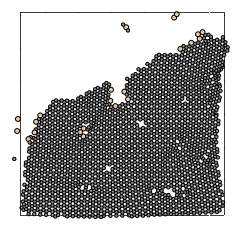

In [ ]:
write_mp4('/content/drive/My Drive/trial_II.mp4',traj)